# VHR example
Let's use EOReader with Very High Resolution data.

## Imports

In [1]:
import os

# EOReader
from eoreader.reader import Reader
from eoreader.bands import GREEN, NDVI, TIR_1, CLOUDS, HILLSHADE, to_str
from eoreader.env_vars import DEM_PATH

## Create the logger

In [2]:
# Create logger
import logging
from sertit import logs

logger = logging.getLogger("eoreader")
logs.init_logger(logger)

# Open the VHR product

Please be aware that EOReader will always work in UTM projection.  
So if you give WGS84 data, EOReader will reproject the stacks and this can be time-consuming

In [3]:
# Set a DEM
os.environ[DEM_PATH] = os.path.join(
    "/home", "data", "DS2", "BASES_DE_DONNEES", "GLOBAL",
    "MERIT_Hydrologically_Adjusted_Elevations", "MERIT_DEM.vrt"
)

# Open your product
path = os.path.join("/home", "data", "DATA", "PRODS", "PLEIADES", "5547047101", "IMG_PHR1A_PMS_001")
reader = Reader()
prod = reader.open(path, remove_tmp=True)
prod

eoreader.PldProduct 'PHR1A_PMS_202005110231585_ORT_5547047101'
Attributes:
	condensed_name: 20200511T023158_PLD_ORT_PMS_5547047101
	path: /home/data/DATA/PRODS/PLEIADES/5547047101/IMG_PHR1A_PMS_001
	constellation: Pleiades
	sensor type: Optical
	product type: Ortho Single Image
	default pixel size: 0.5
	default resolution: 0.5
	acquisition datetime: 2020-05-11T02:31:58
	band mapping:
		BLUE: 3
		GREEN: 2
		RED: 1
		NIR: 4
		NARROW_NIR: 4
	needs extraction: False
	cloud cover: 0.0

In [4]:
# Plot the quicklook
prod.plot()

In [5]:
# Get the bands information
prod.bands

eoreader.SpectralBand 'RED'
Attributes:
	id: 1
	eoreader_name: RED
	common_name: red
	gsd (m): 0.5
	asset_role: reflectance
	Center wavelength (nm): 650.0
	Bandwidth (nm): 120.0
eoreader.SpectralBand 'GREEN'
Attributes:
	id: 2
	eoreader_name: GREEN
	common_name: green
	gsd (m): 0.5
	asset_role: reflectance
	Center wavelength (nm): 560.0
	Bandwidth (nm): 120.0
eoreader.SpectralBand 'BLUE'
Attributes:
	id: 3
	eoreader_name: BLUE
	common_name: blue
	gsd (m): 0.5
	asset_role: reflectance
	Center wavelength (nm): 495.0
	Bandwidth (nm): 70.0
eoreader.SpectralBand 'NIR'
Attributes:
	id: 4
	eoreader_name: NIR
	common_name: nir
	gsd (m): 0.5
	asset_role: reflectance
	Center wavelength (nm): 840.0
	Bandwidth (nm): 200.0
eoreader.SpectralBand 'NIR'
Attributes:
	id: 4
	eoreader_name: NIR
	common_name: nir
	gsd (m): 0.5
	asset_role: reflectance
	Center wavelength (nm): 840.0
	Bandwidth (nm): 200.0

In [6]:
print(f"Acquisition datetime: {prod.datetime}")
print(f"Condensed name: {prod.condensed_name}")

Acquisition datetime: 2020-05-11 02:31:58
Condensed name: 20200511T023158_PLD_ORT_PMS_5547047101


<Axes: >

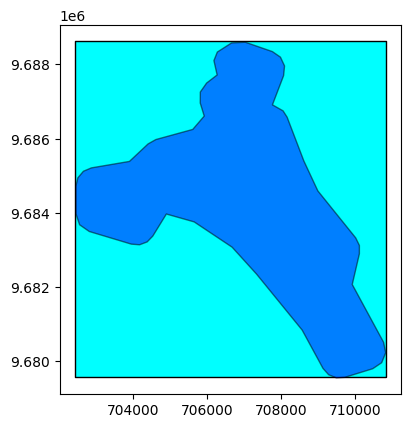

In [7]:
# Open here some more interesting geographical data: extent and footprint
extent = prod.extent()
footprint = prod.footprint()

base = extent.plot(color='cyan', edgecolor='black')
footprint.plot(ax=base, color='blue', edgecolor='black', alpha=0.5)

Here, if you want to orthorectify or pansharpen your data manually, you can set your stack here.

```python
prod.ortho_stack = "/path/to/ortho_stack.tif"
```

If you do not provide this stack, but you give a non-orthorectified product to EOReader
(i.e. `SEN` or `PRJ` products for Pleiades), you must provide a DEM to orthorectify correctly the data.

⚠⚠⚠
DIMAP SEN products are orthorectified using RPCs and not the rigorous sensor model.
A shift of several meters can occur.
Please refer to [this issue](https://github.com/sertit/eoreader/issues/53).


## Load some bands

In [8]:
# Select the bands you want to load
bands = [GREEN, NDVI, TIR_1, CLOUDS, HILLSHADE]

# Be sure they exist for Pleiades sensor
ok_bands = [band for band in bands if prod.has_band(band)]
print(to_str(ok_bands))  # Pleiades doesn't provide TIR and SHADOWS bands

['GREEN', 'NDVI', 'CLOUDS', 'HILLSHADE']


In [ ]:
# Load those bands as a xarray.Dataset
band_ds = prod.load(ok_bands)
band_ds[GREEN]

2023-05-31 11:47:20,447 - [DEBUG] - Loading bands ['GREEN', 'NIR', 'RED']
2023-05-31 11:47:20,453 - [DEBUG] - Read GREEN
2023-05-31 11:47:20,573 - [INFO] - Warping DIM_PHR1A_PMS_202005110231585_ORT_5547047101 to UTM with a 0.5 m pixel size.
2023-05-31 11:47:20,844 - [DEBUG] - Reading warped GREEN.
2023-05-31 11:47:21,261 - [DEBUG] - Manage nodata for band GREEN
2023-05-31 11:47:28,021 - [DEBUG] - Converting GREEN to reflectance
2023-05-31 11:58:09,959 - [DEBUG] - Read NIR
2023-05-31 11:58:10,429 - [INFO] - Warping DIM_PHR1A_PMS_202005110231585_ORT_5547047101 to UTM with a 0.5 m pixel size.
2023-05-31 11:58:10,550 - [DEBUG] - Reading warped NIR.
2023-05-31 11:58:11,231 - [DEBUG] - Manage nodata for band NIR
2023-05-31 11:58:12,656 - [DEBUG] - Converting NIR to reflectance
2023-05-31 11:59:40,816 - [DEBUG] - Read RED
2023-05-31 11:59:40,902 - [INFO] - Warping DIM_PHR1A_PMS_202005110231585_ORT_5547047101 to UTM with a 0.5 m pixel size.
2023-05-31 11:59:40,964 - [DEBUG] - Reading warped RE

In [ ]:
# The nan corresponds to the nodata you see on the footprint
# Plot a subsampled version
band_ds[GREEN][:, ::10, ::10].plot()

In [ ]:
# Plot a subsampled version
band_ds[NDVI][:, ::10, ::10].plot()

In [ ]:
# Plot a subsampled version
band_ds[CLOUDS][:, ::10, ::10].plot()

In [ ]:
# Plot a subsampled version
band_ds[HILLSHADE][:, ::10, ::10].plot()

## Stack some bands

In [ ]:
# You can also stack those bands
stack = prod.stack(ok_bands)

In [ ]:
# Plot a subsampled version
import matplotlib.pyplot as plt

nrows = len(stack)
fig, axes = plt.subplots(nrows=nrows, figsize=(2 * nrows, 6 * nrows), subplot_kw={"box_aspect": 1})

for i in range(nrows):
    stack[i, ::10, ::10].plot(x="x", y="y", ax=axes[i])